In [1]:
import sys
sys.path.append('../src')
import numpy as np
import rebound
import matplotlib.pyplot as plt
import astropy.constants as const
from lightcurve import LightCurve
from ttv import TransitTimingVariations

# One Planet Code Test

## Run Simulation with No Variable Timestep
One planet simulation is ran and the TTV curve of the object is calculated in the following code

### Setup Parameters
First, we setup the simulation parameters

In [2]:
'''
Setup Simulation Parameters
'''
# Create a simulation
sim_novar = rebound.Simulation()

# Set up units
sim_novar.units = ('AU', 's', 'Msun')


# Define the timesteps 
# In this case both are the same as there will be no variable timestep for the first run
large_dt = 1e3
small_dt = 1e3

# Set the total simulation time
year = 60*60*24*325.25 # seconds/year
t_total = 10*year

Next, we setup the objects for simulation

In [3]:
'''
Set Up Objects for Simulation
'''
# Names of objects
names = ["Star","Planet A"]

# Add the Star
sim_novar.add(m=1.0,hash=names[0])

# Add planet A that uses Venus's parameters
sim_novar.add(m=2.45e-6, a=0.72, e=0.007,hash=names[1])

# Radii of planets
radii = np.array([109,0.949]) 

This sets up the variable timestep parameters

In [4]:
'''
Set up Parameters for Variable Timestep in Simulation
'''
# Retrieve star radius
s_radius = radii[0]

# Find largest radius from planets
max_planet_radius = max(radii[1:])

# Add a buffer to this radius therefore the smaller timestep occurs before/after transit begins/ends
buffer = 10
max_planet_radius += buffer

# Define the entering and exiting transit region and ensure units are in AU (match simulation units)
entering = (-s_radius-max_planet_radius)  * const.R_earth.value/const.au.value
exiting = (s_radius+max_planet_radius)  * const.R_earth.value/const.au.value

### Run the simulation

In [5]:
'''
Run the Simulation
'''
# Create arrays to store positions and time
positions_x = []
positions_y = []
time = []
sim_novar.move_to_com()
# Integrate the simulation until total time
while sim_novar.t<=t_total:
    # Set timestep to large dt unless planet is in transit region
    dt = large_dt

    # Record positions
    positions_x.append(np.array([p.x for p in sim_novar.particles]))
    positions_y.append(np.array([p.y for p in sim_novar.particles]))

    # Retrieve position of planets
    planet_pos = positions_y[-1][1:]
    in_transit = np.logical_and(planet_pos>entering, planet_pos<exiting)
    
    # If any planet is in the transit region use a smaller timestep
    if np.sum(in_transit)>=1:
        if np.any(positions_x[-1][1:][in_transit]>0):
            dt = small_dt

    sim_novar.dt=dt
    time.append(sim_novar.t+sim_novar.dt)
    sim_novar.integrate(sim_novar.t+sim_novar.dt)

In [6]:
# Convert everything back to numpy array
positions_x = np.array(positions_x)
positions_y = np.array(positions_y)
time = np.array(time)


Plot the orbit

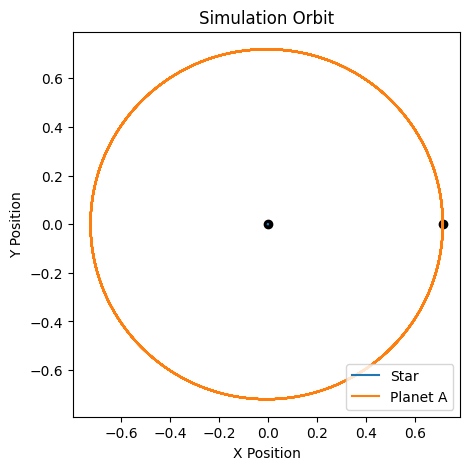

In [7]:
# Plot orbit
plt.figure(figsize=(5,5))
for i in range(len(radii)):
    plt.plot(positions_x[0,i],positions_y[0,i],c='k',ls='none',marker='o')
    plt.plot(positions_x[:,i],positions_y[:,i],label=names[i])
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Simulation Orbit")
plt.legend()

### Create lightcurves for object

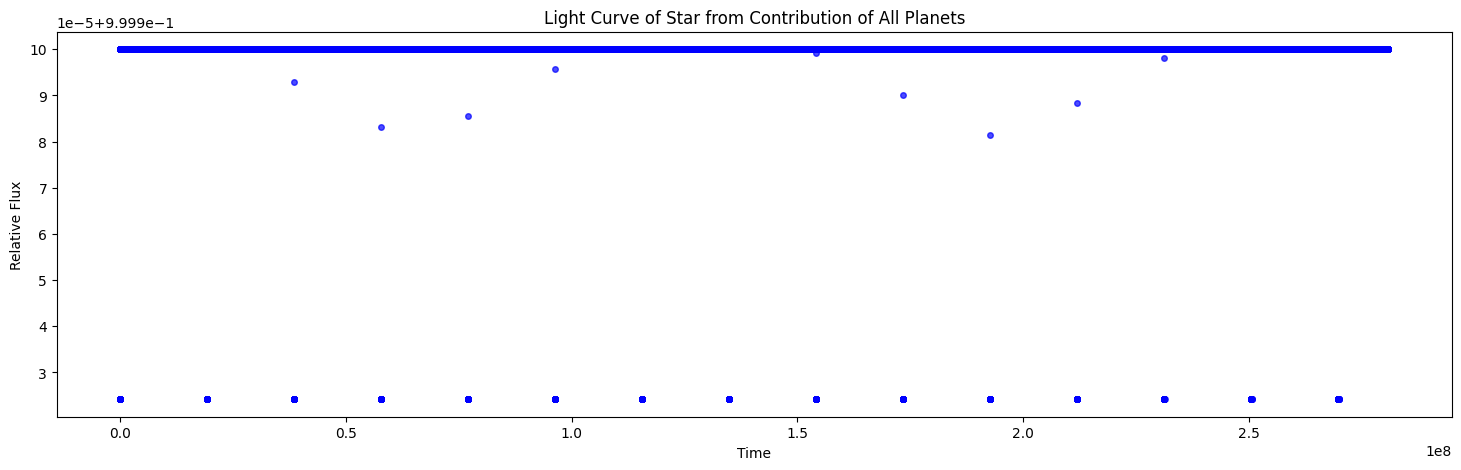

In [8]:
LC = LightCurve(radii_objects=radii,rad_unit="REarth",dist_unit="AU",xgrid=time)
objects = LC.compute_lightcurve(positions_x.copy(),positions_y.copy(),names)
fig = LC.plot_total_lc(objects,18,5)

### Compute TTVs

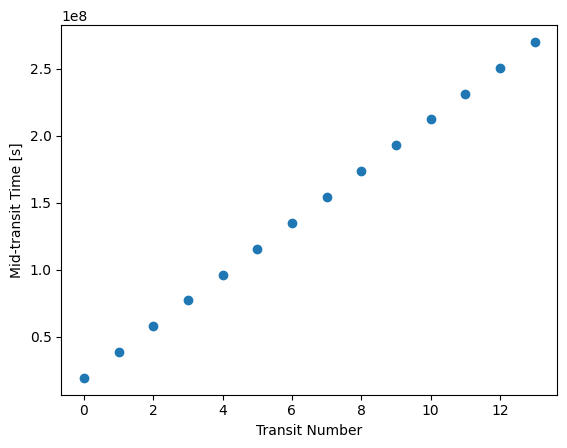

In [9]:
TTVinit = TransitTimingVariations(objects,1e3,names[1])

# First we calculate the mid transit times
MTTs = TTVinit.compute_MTTs(plotfig=True,method="interpolate")

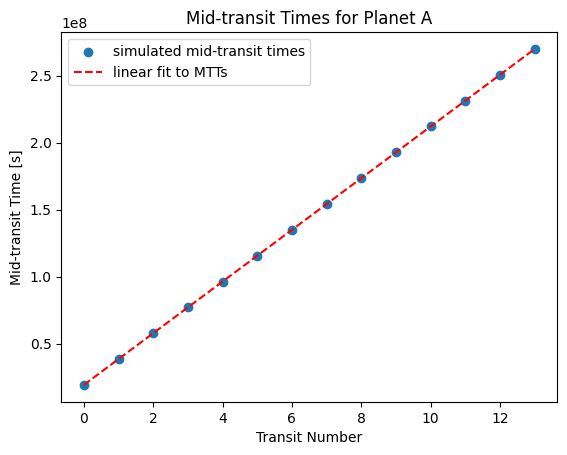

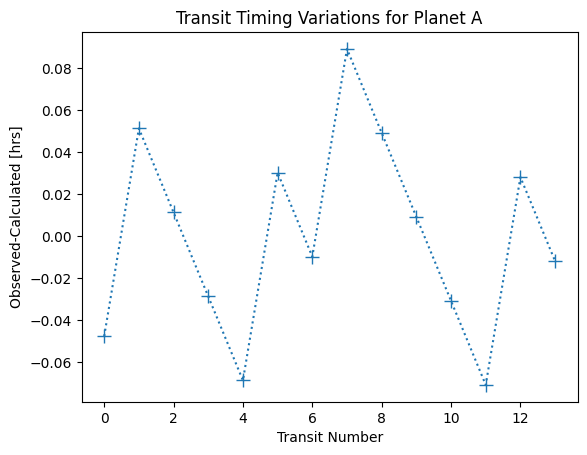

In [10]:
# Then we find the TTV curve
TTVs_novar = TTVinit.compute_TTVs(plotfig=True,plot_time_units="hrs")

## Run Simulation with Variable Timestep
One planet simulation is ran and the TTV curve of the object is calculated in the following code

### Setup Parameters
First, we setup the simulation parameters

In [11]:
'''
Setup Simulation Parameters
'''
# Create a simulation
sim = rebound.Simulation()

# Set up units
sim.units = ('AU', 's', 'Msun')


# Define the timesteps 
large_dt = 1e3
small_dt = 1e-1

# Set the total simulation time
year = 60*60*24*325.25 # seconds/year
t_total = 10*year

Then we setup objects for the simulation

In [12]:
'''
Set Up Objects for Simulation
'''
# Names of objects
names = ["Star","Planet A"]

# Add the Star
sim.add(m=1.0,hash=names[0])

# Add planet A that uses Venus's parameters
sim.add(m=2.45e-6, a=0.72, e=0.007,hash=names[1])

# Radii of planets
radii = np.array([109,0.949]) 

Then we setup parameteres for variable timestep in simulation

In [13]:
'''
Set up Parameters for Variable Timestep in Simulation
'''
# Retrieve star radius
s_radius = radii[0]

# Find largest radius from planets
max_planet_radius = max(radii[1:])

# Add a buffer to this radius therefore the smaller timestep occurs before/after transit begins/ends
buffer = 10
max_planet_radius += buffer

# Define the entering and exiting transit region and ensure units are in AU (match simulation units)
entering = (-s_radius-max_planet_radius)  * const.R_earth.value/const.au.value
exiting = (s_radius+max_planet_radius)  * const.R_earth.value/const.au.value

### Run the simulation

In [14]:
'''
Run the Simulation
'''
# Create arrays to store positions and time
positions_x = []
positions_y = []
time = []

sim.move_to_com()
# Integrate the simulation until total time
while sim.t<=t_total:
    # Set timestep to large dt unless planet is in transit region
    dt = large_dt

    # Record positions
    positions_x.append(np.array([p.x for p in sim.particles]))
    positions_y.append(np.array([p.y for p in sim.particles]))

    # Retrieve position of planets
    planet_pos = positions_y[-1][1:]
    in_transit = np.logical_and(planet_pos>entering, planet_pos<exiting)
    
    # If any planet is in the transit region use a smaller timestep
    if np.sum(in_transit)>=1:
        if np.any(positions_x[-1][1:][in_transit]>0):
            dt = small_dt

    sim.dt=dt
    time.append(sim.t+sim.dt)
    sim.integrate(sim.t+sim.dt)

In [15]:
# Convert everything back to numpy array
positions_x = np.array(positions_x)
positions_y = np.array(positions_y)
time = np.array(time)

/Users/dhvanidoshi/environs/compphys/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/dhvanidoshi/environs/compphys/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


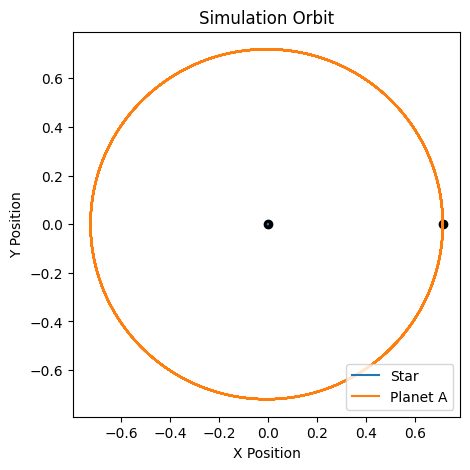

In [16]:
# Plot orbit
plt.figure(figsize=(5,5))
for i in range(len(radii)):
    plt.plot(positions_x[0,i],positions_y[0,i],c='k',ls='none',marker='o')
    plt.plot(positions_x[:,i],positions_y[:,i],label=names[i])
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Simulation Orbit")
plt.legend()

### Calculate lightcurve

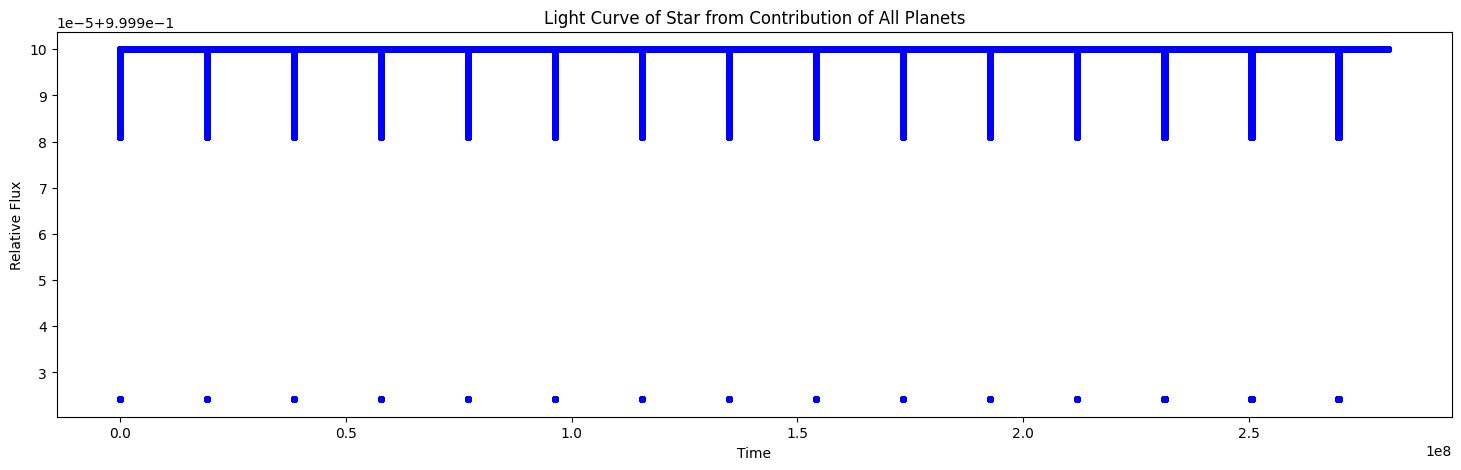

In [17]:
LC = LightCurve(radii_objects=radii,rad_unit="REarth",dist_unit="AU",xgrid=time)
objects = LC.compute_lightcurve(positions_x.copy(),positions_y.copy(),names)
fig = LC.plot_total_lc(objects,18,5)

### Calculate TTV

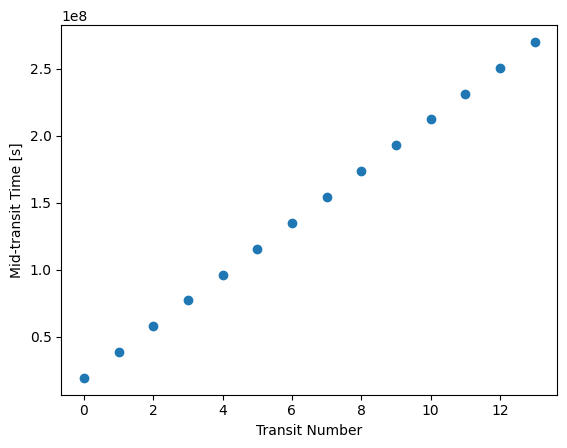

In [18]:
TTVinit = TransitTimingVariations(objects,1e3,names[1])

# First we calculate the mid transit times
MTTs = TTVinit.compute_MTTs(plotfig=True,method="interpolate")

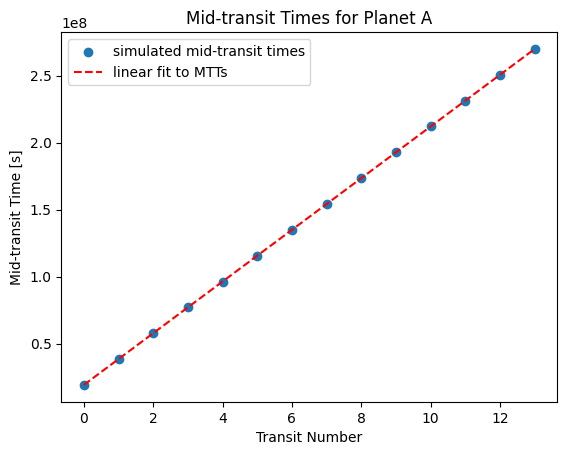

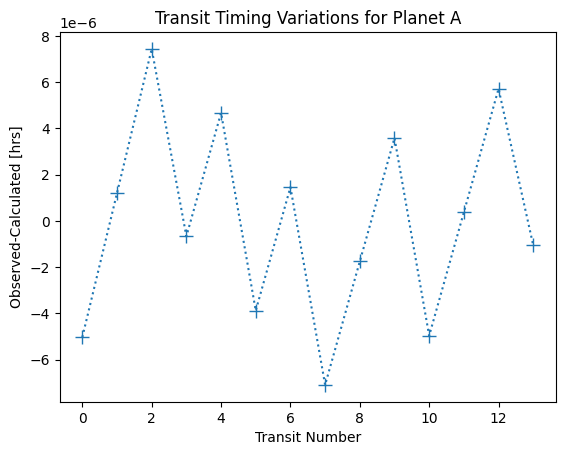

In [19]:
# Then we find the TTV curve
TTVs = TTVinit.compute_TTVs(plotfig=True,plot_time_units="hrs")

# Comparison Plot
This plot compares the TTV of the same orbit with and without the variable timestep

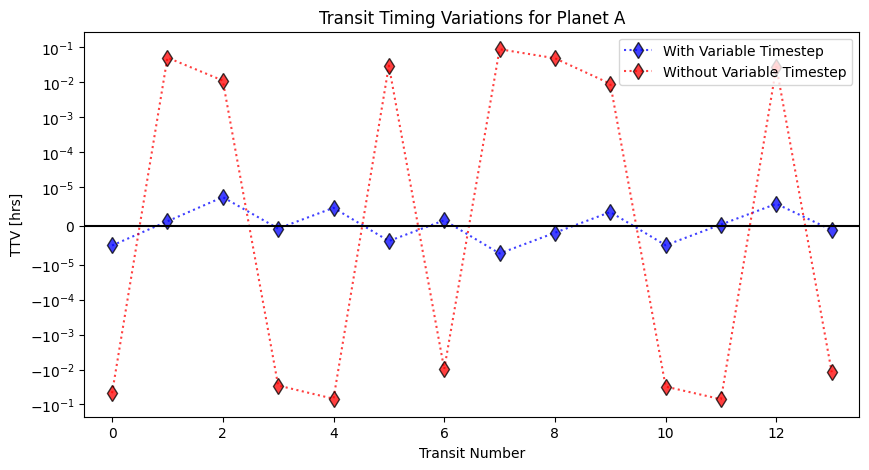

In [20]:
plt.figure(figsize=(10,5))
seconds_per_hour = 60*60
plt.plot(TTVs/seconds_per_hour,ls=':',marker='d',ms=8,c="b",label="With Variable Timestep",alpha=0.75,markeredgecolor="k")
plt.plot(TTVs_novar/seconds_per_hour,ls=':',marker='d',ms=8,c="r",label="Without Variable Timestep",alpha=0.75,markeredgecolor="k")
plt.plot(np.arange(-1,15),np.zeros(16),c="k")
plt.title("Comparing TTV Curve for One Planet With and Without the Variable Timestep")
plt.xlabel('Transit Number')
plt.ylabel('TTV [hrs]')
plt.title('Transit Timing Variations for '+names[1])
plt.legend()
plt.yscale("symlog",linthresh=1e-5)
plt.xlim(-0.5,13.5)
plt.savefig("one_planet.pdf")
plt.show()